In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e1-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
num_samples=100

Correlation-Aware Sparse Bayesian Learning (CA-SBL)

In [4]:
def casbl_algorithm(A, y, N, sig2e, Tau_p, loc, kappa=5.725, D=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if kappa == 0:
        G = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / kappa) - np.exp(-D / kappa)) / (1 - np.exp(-D / kappa)),0)

        # Compute G as the inverse of the correlation matrix
        G = np.linalg.solve(correlation_matrix, np.eye(correlation_matrix.shape[0]))

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
        mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

        # Compute Q (denoted as B in the image)
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P (denoted as A_3 in the image)
        P = 2 * (G @ np.diag(Gamma))
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
    mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [5]:
# Placeholder arrays for casbl results
z_casbl = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # casbl results
gamma_casbl = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # casbl gamma values
hit_rate_casbl = np.zeros((num_samples, len(pilot_length_array)))  # Hit rate for casbl
support_recovery_rate_casbl = np.zeros((num_samples, len(pilot_length_array)))  # Miss detection rate for casbl
false_alarm_rate_casbl = np.zeros((num_samples, len(pilot_length_array)))  # False alarm rate for casbl
norm_mse_casbl = np.zeros((num_samples, len(pilot_length_array)))  # Norm MSE for casbl

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply casbl algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length, loc)

        # Store the results
        z_result[gamma_result <= 0.05] = 0
        z_casbl[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_casbl[sample_index, pilot_length_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for casbl
        hit_rate_casbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the support recovery rate for casbl
        support_recovery_rate_casbl[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool ==1) & (gamma == 1))
            /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Calculate the false alarm rate for casbl
        false_alarm_rate_casbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for casbl
        norm_mse_casbl[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )  # Avoid division by zero


Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.55s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.44s/it]

Converged after 326 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:41<00:53, 26.97s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [02:07<00:26, 26.62s/it]

Converged after 386 outer iterations



Processing Samples:   3%|▎         | 3/100 [05:34<3:08:33, 116.63s/it]

Converged after 319 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.09s/it]

Converged after 319 outer iterations



Processing Samples:   4%|▍         | 4/100 [07:02<2:48:33, 105.35s/it]

Converged after 280 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.45s/it]

Converged after 387 outer iterations



Processing Samples:   5%|▌         | 5/100 [08:37<2:40:53, 101.62s/it]

Converged after 242 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.17s/it]

Converged after 417 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.00s/it]

Converged after 320 outer iterations



Processing Samples:  10%|█         | 10/100 [16:58<2:28:01, 98.69s/it]

Converged after 301 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.87s/it]

Converged after 371 outer iterations



Processing Samples:  11%|█         | 11/100 [18:33<2:24:56, 97.71s/it]

Converged after 337 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.69s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.34s/it]

Converged after 409 outer iterations



Processing Samples:  12%|█▏        | 12/100 [20:02<2:19:10, 94.90s/it]

Converged after 245 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.66s/it]

Converged after 432 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.05s/it]

Converged after 289 outer iterations



Processing Samples:  15%|█▌        | 15/100 [24:52<2:13:55, 94.54s/it]

Converged after 290 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.56s/it]

Converged after 414 outer iterations



Processing Samples:  16%|█▌        | 16/100 [26:29<2:13:23, 95.28s/it]

Converged after 380 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:32, 16.04s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.06s/it]

Converged after 311 outer iterations



Processing Samples:  17%|█▋        | 17/100 [27:59<2:09:30, 93.62s/it]

Converged after 249 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.30s/it]

Converged after 441 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.44s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.69s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.37s/it]

Converged after 389 outer iterations



Processing Samples:  21%|██        | 21/100 [34:33<2:06:18, 95.93s/it]

Converged after 261 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.94s/it]

Converged after 416 outer iterations



Processing Samples:  22%|██▏       | 22/100 [36:09<2:05:02, 96.18s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.69s/it]

Converged after 354 outer iterations



Processing Samples:  24%|██▍       | 24/100 [39:24<2:01:33, 95.96s/it]

Converged after 288 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.27s/it]

Converged after 361 outer iterations



Processing Samples:  25%|██▌       | 25/100 [40:55<1:58:24, 94.73s/it]

Converged after 297 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.43s/it]

Converged after 417 outer iterations



Processing Samples:  26%|██▌       | 26/100 [42:32<1:57:37, 95.38s/it]

Converged after 342 outer iterations



Processing Samples:  28%|██▊       | 28/100 [45:51<1:56:35, 97.16s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.61s/it]

Converged after 476 outer iterations



Processing Samples:  29%|██▉       | 29/100 [47:27<1:54:27, 96.72s/it]

Converged after 325 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.70s/it]

Converged after 489 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.82s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.18s/it]

Converged after 477 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.40s/it]

Converged after 296 outer iterations



Processing Samples:  32%|███▏      | 32/100 [52:19<1:48:57, 96.13s/it]

Converged after 310 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.61s/it]

Converged after 364 outer iterations



Processing Samples:  34%|███▍      | 34/100 [55:31<1:45:13, 95.66s/it]

Converged after 257 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.98s/it]

Converged after 407 outer iterations



Processing Samples:  35%|███▌      | 35/100 [57:01<1:41:43, 93.90s/it]

Converged after 233 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.62s/it]

Converged after 468 outer iterations



Processing Samples:  39%|███▉      | 39/100 [1:03:48<1:40:28, 98.83s/it] 

Converged after 329 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.61s/it]

Converged after 377 outer iterations



Processing Samples:  40%|████      | 40/100 [1:05:22<1:37:21, 97.36s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.53s/it]

Converged after 441 outer iterations



Processing Samples:  41%|████      | 41/100 [1:06:57<1:34:58, 96.58s/it]

Converged after 311 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.75s/it]

Converged after 371 outer iterations



Processing Samples:  42%|████▏     | 42/100 [1:08:28<1:31:51, 95.02s/it]

Converged after 295 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:16, 16.02s/it]

Converged after 434 outer iterations



Processing Samples:  44%|████▍     | 44/100 [1:11:45<1:29:34, 95.97s/it]

Converged after 274 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.01s/it]

Converged after 355 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.83s/it]

Converged after 313 outer iterations



Processing Samples:  45%|████▌     | 45/100 [1:13:05<1:23:38, 91.24s/it]

Converged after 228 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.22s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.29s/it]

Converged after 330 outer iterations



Processing Samples:  47%|████▋     | 47/100 [1:16:18<1:22:16, 93.15s/it]

Converged after 299 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.34s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.96s/it]

Converged after 384 outer iterations



Processing Samples:  48%|████▊     | 48/100 [1:17:46<1:19:26, 91.67s/it]

Converged after 298 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.26s/it]

Converged after 469 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.56s/it]

Converged after 399 outer iterations



Processing Samples:  49%|████▉     | 49/100 [1:19:16<1:17:30, 91.19s/it]

Converged after 284 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.13s/it]

Converged after 330 outer iterations



Processing Samples:  50%|█████     | 50/100 [1:20:49<1:16:33, 91.86s/it]

Converged after 409 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.09s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.31s/it]

Converged after 364 outer iterations



Processing Samples:  53%|█████▎    | 53/100 [1:25:48<1:15:21, 96.21s/it]

Converged after 402 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.81s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.83s/it]

Converged after 351 outer iterations



Processing Samples:  58%|█████▊    | 58/100 [1:34:12<1:08:41, 98.13s/it] 

Converged after 327 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:17, 17.42s/it]

Converged after 469 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:33, 16.64s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.61s/it]

Converged after 436 outer iterations



Processing Samples:  63%|██████▎   | 63/100 [1:42:47<1:02:05, 100.69s/it]

Converged after 334 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.47s/it]

Converged after 351 outer iterations



Processing Samples:  65%|██████▌   | 65/100 [1:46:03<57:38, 98.81s/it]   

Converged after 308 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.12s/it]

Converged after 420 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.01s/it]

Converged after 429 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.14s/it]

Converged after 359 outer iterations



Processing Samples:  69%|██████▉   | 69/100 [1:52:46<51:01, 98.77s/it] 

Converged after 312 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:47, 15.86s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.20s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.74s/it]

Converged after 366 outer iterations



Processing Samples:  73%|███████▎  | 73/100 [1:59:24<43:41, 97.11s/it] 

Converged after 262 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.55s/it]

Converged after 311 outer iterations



Processing Samples:  75%|███████▌  | 75/100 [2:02:37<40:03, 96.13s/it]

Converged after 275 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.80s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.09s/it]

Converged after 411 outer iterations



Processing Samples:  76%|███████▌  | 76/100 [2:04:10<38:07, 95.31s/it]

Converged after 316 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.43s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.91s/it]

Converged after 416 outer iterations



Processing Samples:  77%|███████▋  | 77/100 [2:05:41<36:00, 93.93s/it]

Converged after 275 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.51s/it]

Converged after 324 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.35s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.56s/it]

Converged after 358 outer iterations



Processing Samples:  80%|████████  | 80/100 [2:10:33<31:37, 94.89s/it]

Converged after 316 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.49s/it]

Converged after 465 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.49s/it]

Converged after 374 outer iterations



Processing Samples:  82%|████████▏ | 82/100 [2:13:48<28:42, 95.69s/it]

Converged after 304 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.05s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.97s/it]

Converged after 349 outer iterations



Processing Samples:  84%|████████▍ | 84/100 [2:16:59<25:16, 94.76s/it]

Converged after 278 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.24s/it]

Converged after 357 outer iterations



Processing Samples:  85%|████████▌ | 85/100 [2:18:30<23:26, 93.74s/it]

Converged after 243 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.26s/it]

Converged after 316 outer iterations



Processing Samples:  87%|████████▋ | 87/100 [2:21:49<20:49, 96.14s/it]

Converged after 356 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.46s/it]

Converged after 434 outer iterations



Processing Samples:  88%|████████▊ | 88/100 [2:23:25<19:11, 95.98s/it]

Converged after 316 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.54s/it]

Converged after 357 outer iterations



Processing Samples:  89%|████████▉ | 89/100 [2:24:58<17:27, 95.25s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.00s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.44s/it]

Converged after 355 outer iterations



Processing Samples:  91%|█████████ | 91/100 [2:28:06<14:01, 93.55s/it]

Converged after 216 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.77s/it]

Converged after 335 outer iterations



Processing Samples:  93%|█████████▎| 93/100 [2:31:19<11:02, 94.68s/it]

Converged after 275 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:24<00:42, 21.36s/it]

Converged after 403 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:43<00:20, 20.20s/it]

Converged after 358 outer iterations



Processing Samples:  94%|█████████▍| 94/100 [2:33:17<10:10, 101.69s/it]

Converged after 271 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:30<00:44, 22.48s/it]

Converged after 466 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:41<00:18, 18.59s/it]

Converged after 313 outer iterations



Processing Samples:  95%|█████████▌| 95/100 [2:35:10<08:44, 104.90s/it]

Converged after 246 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.17s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.48s/it]

Converged after 363 outer iterations



Processing Samples:  98%|█████████▊| 98/100 [2:40:07<03:20, 100.04s/it]

Converged after 408 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.59s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.57s/it]

Converged after 473 outer iterations



Processing Samples: 100%|██████████| 100/100 [2:43:17<00:00, 97.97s/it]

Converged after 292 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hit_rate_casbl = np.mean(hit_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_support_recovery_rate_casbl = np.mean(support_recovery_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_casbl = np.mean(false_alarm_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_casbl = np.mean(norm_mse_casbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_casbl)
print("Average Support Recovery Rate across samples per SNR level:", avg_support_recovery_rate_casbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_casbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_casbl)

Average Hit Rate across samples per SNR level: [51.7 80.  95.9 99.8 99.9 99.8]
Average Support Recovery Rate across samples per SNR level: [0.13993831 0.32257127 0.63431937 0.86978012 0.95565268 0.98075758]
Average False Alarm Rate across samples per SNR level: [6.03589744 3.70769231 1.37435897 0.41794872 0.12820513 0.04615385]
Average Normalized MSE across samples per SNR level: [0.7937113  0.51705524 0.16287866 0.05354377 0.03141068 0.02400866]


In [8]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/data/results/e1-results-100-casbl-ic-pilot-length-all-snr-db-12.npz',
                    z_casbl=z_casbl,
                    gamma_casbl=gamma_casbl,
                    hit_rate_casbl=hit_rate_casbl,
                    support_recovery_rate_casbl=support_recovery_rate_casbl,
                    false_alarm_rate_casbl=false_alarm_rate_casbl,
                    norm_mse_casbl=norm_mse_casbl,
                    avg_hit_rate_casbl=avg_hit_rate_casbl,
                    avg_support_recovery_rate_casbl=avg_support_recovery_rate_casbl,
                    avg_false_alarm_rate_casbl=avg_false_alarm_rate_casbl,
                    avg_norm_mse_casbl=avg_norm_mse_casbl,
                    pilot_length_array=pilot_length_array,
                    snr_db=snr_db)

print("All results have been saved to 'communication_simulation_results_all_samples.npz'.")

All results have been saved to 'communication_simulation_results_all_samples.npz'.


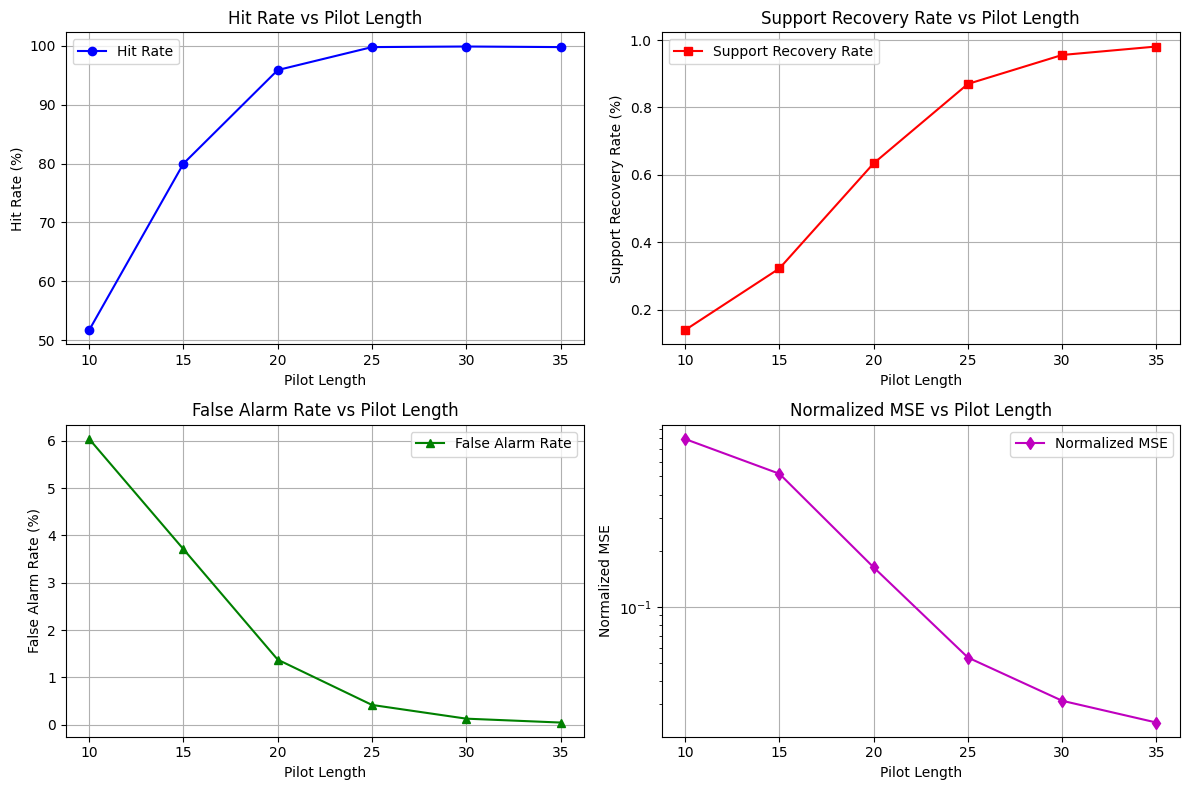

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(pilot_length_values, avg_hit_rate_casbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Miss Detection Rate
plt.subplot(2, 2, 2)
plt.plot(pilot_length_values, avg_support_recovery_rate_casbl, marker='s', linestyle='-', color='r', label='Support Recovery Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate (%)")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(pilot_length_values, avg_false_alarm_rate_casbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(pilot_length_values, avg_norm_mse_casbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
